In [473]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import math

In [ ]:
df = pd.read_csv('data.csv')
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

df = df.fillna(0)

#Rain binary classification
if 'Total Precip (in)' in df.columns:
    df['Total Precip (in)'] = df['Total Precip (in)'].fillna(0)
    df['Has_Precip'] = (df['Total Precip (in)'] > 0).astype(int)

df['Hour'] = df['Date/Time'].dt.hour
df['Month'] = df['Date/Time'].dt.month
df['Day_of_Year'] = df['Date/Time'].dt.dayofyear
df['Day_of_Week'] = df['Date/Time'].dt.dayofweek

# Handle wind direction - convert to sine and cosine components
if 'Wind Direction (°)' in df.columns:
    # Fill missing values with the median
    wind_dir_median = df['Wind Direction (°)'].median()
    df['Wind Direction (°)'] = df['Wind Direction (°)'].fillna(wind_dir_median)
    
    # Convert to sine and cosine components
    df['Wind_Sin'] = np.sin(np.radians(df['Wind Direction (°)']))
    df['Wind_Cos'] = np.cos(np.radians(df['Wind Direction (°)']))

# Convert pressure trend code to numerical if it exists
if 'Pressure Trend Code' in df.columns:
    trend_map = {'F': -1, 'S': 0, 'R': 1}
    # Handle missing or unexpected values
    df['Pressure_Trend_Num'] = df['Pressure Trend Code'].map(trend_map).fillna(0)

len(df)

41454

In [475]:
input_features = ['Temperature (°F)', 'Wind Direction (°)', 'Humidity (%)', 'UV Index', 'Hour', 'Month']
output_feature = ["Has_Precip"]

has_precip = df[df['Has_Precip'] == 1]
no_precip = df[df['Has_Precip'] == 0]

has_precip_sample = has_precip.sample(n=500, random_state=42)
no_precip_sample = no_precip.sample(n=500, random_state=42)

balanced_df = pd.concat([has_precip_sample, no_precip_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

input_features_df = balanced_df[input_features]
output_feature_df = balanced_df[output_feature]


In [476]:
input_features_matrix = input_features_df.to_numpy()
print(input_features_matrix)

output_feature_vector = output_feature_df.to_numpy().flatten()
print(output_feature_vector)

[[ 48. 300.  71.   0.   8.  11.]
 [ 64.  80.  77.   0.  12.  10.]
 [ 10. 330.  53.   0.   9.   2.]
 ...
 [ 46. 110.  68.   1.  20.   3.]
 [ 37. 290.  54.   0.  11.  12.]
 [ 61.  60.  90.   0.  11.   9.]]
[0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0
 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0
 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1
 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0
 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0
 0 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0
 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1
 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0
 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0
 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0

In [477]:
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(input_features_matrix)
X_scale = np.hstack((X_scale, np.ones((X_scale.shape[0], 1))))
X_scale

array([[0.46236559, 0.83333333, 0.6547619 , ..., 0.34782609, 0.90909091,
        1.        ],
       [0.6344086 , 0.22222222, 0.72619048, ..., 0.52173913, 0.81818182,
        1.        ],
       [0.05376344, 0.91666667, 0.44047619, ..., 0.39130435, 0.09090909,
        1.        ],
       ...,
       [0.44086022, 0.30555556, 0.61904762, ..., 0.86956522, 0.18181818,
        1.        ],
       [0.34408602, 0.80555556, 0.45238095, ..., 0.47826087, 1.        ,
        1.        ],
       [0.60215054, 0.16666667, 0.88095238, ..., 0.47826087, 0.72727273,
        1.        ]], shape=(1000, 7))

In [478]:
phi = X_scale
y = output_feature_vector

In [479]:
Phi_train, Phi_test, y_train, y_test = train_test_split(phi, y, test_size=0.2)

In [480]:
eta = 0.01

W1 = np.random.randn(len(input_features) + 1,4)
W2 = np.random.randn(4,1)
Phi_train.shape

(800, 7)

In [481]:
def f(x):
    h = np.maximum(0, W1.T.dot(x))
    return 1/ (1 + math.e**(-1*(W2.T.dot(h))))

# descent
errors = []
epochs = 500
n = Phi_train.shape[0]
for epoch in range(epochs):
    dW2 = 0
    # first weight and derivative 
    for i, j in enumerate(y_train):
        #reshape first set
        x = np.reshape(Phi_train[i], (len(input_features) + 1,1))
        f_x = f(x)
        h = np.maximum(0, W1.T.dot(x))
        dW2 += (1/n) * (f_x - y_train[i])*h

    W2 = W2 - eta * dW2

    #W1 derivative
    dW1 = 0
    for i, j in enumerate(y_train):
        x = np.reshape(Phi_train[i], (len(input_features) + 1,1))
        relu_derivative = (W1.T.dot(x) > 0).astype(float)  # Derivative of ReLU
        gradient = (f_x - y_train[i]) * W2 * relu_derivative
    
        
        # Update accumulated gradient
        dW1 += (1/n) * np.outer(x,(gradient.T))

    # After loop, update W1
    W1 = W1 - eta * dW1
    e = (1/n) * np.sum(np.square(f(Phi_train.T) - y_train))
    errors.append(e)

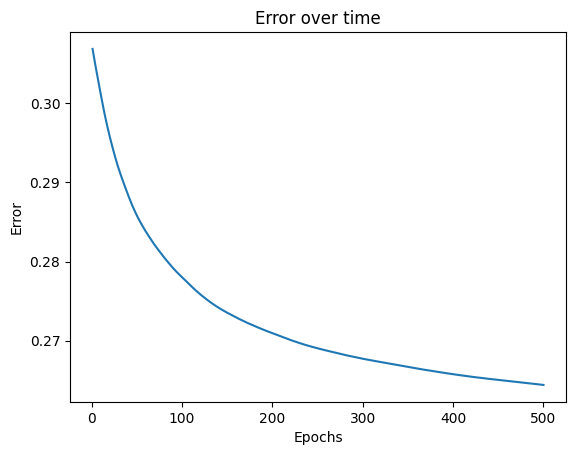

In [482]:
plt.plot(range(1, epochs + 1), errors, label='line')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error over time')
plt.show()

In [483]:
accuracy = np.mean(np.round(f(Phi_test.T)) == y_test)
print(f"Accuracy: {accuracy * 100}%")
print(np.sum(np.round(f(Phi_test.T)) == 1))


Accuracy: 45.5%
79
